<a href="https://colab.research.google.com/github/WENDELLDELIMA/Mestrado_Mackenzie_Aprendizado_Maquina_MLP_IBOVESPA/blob/main/GHG_ESTUDO_INICIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Bloco 1: Preparação da Série Temporal (1990-2010)

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# --- Assumindo df_merged (com o Per Capita) está na memória ---

# 1. Filtrar apenas os dados do Brasil
df_br = df_merged[df_merged['Country/Region'] == 'Brazil'].copy()

# 2. Preparar o DataFrame no formato Prophet (ds, y)
df_prophet_br = df_br[['Year', 'Emissions_Per_Capita_t_CO2eq']].copy()
df_prophet_br['ds'] = pd.to_datetime(df_prophet_br['Year'].astype(str) + '-01-01')
df_prophet_br.rename(columns={'Emissions_Per_Capita_t_CO2eq': 'y'}, inplace=True)
df_prophet_br = df_prophet_br[['ds', 'y']]

# 3. Divisão Treino/Teste
# Treino: Série Histórica (1990-2010)
df_train = df_prophet_br[df_prophet_br['ds'].dt.year <= 2010]

# Teste/Validação: Período Pós-Quebra (2011-2020)
df_test = df_prophet_br[df_prophet_br['ds'].dt.year > 2010].reset_index(drop=True)

print(f"✅ Treinamento: 1990 a {df_train['ds'].max().year} ({len(df_train)} pontos)")
print(f"✅ Validação: {df_test['ds'].min().year} a {df_test['ds'].max().year} ({len(df_test)} pontos)")

✅ Treinamento: 1990 a 2010 (21 pontos)
✅ Validação: 2011 a 2019 (9 pontos)


In [ ]:
# Bloco 2: Treinamento e Projeção (1990-2010)

# 1. Configurar e Treinar o Modelo
# Usamos changepoint_prior_scale alto (ex: 0.1) para dar flexibilidade máxima,
# permitindo que o modelo capture a tendência pré-quebra sem rigidez excessiva.
m = Prophet(
    yearly_seasonality=False,
    changepoint_prior_scale=0.1
)
m.fit(df_train)

# 2. Preparar o Future DataFrame (para 2011-2020)
# Precisamos de 10 períodos futuros (2020 - 2011 + 1 = 10 anos)
num_future_periods = len(df_test) + 1 # Added 1 to include the last year in the forecast horizon for slicing

# Include history = False to avoid merging issues later
# Corrected frequency to 'YS' (Year Start) to match df_test date format
future = m.make_future_dataframe(periods=num_future_periods, freq='YS', include_history=False)


# 3. Gerar a Projeção
forecast = m.predict(future)


# 4. Filter the forecast to include only the dates present in df_test
# Corrected filtering logic to use isin directly on datetime values
forecast_test = forecast[forecast['ds'].isin(df_test['ds'])].copy()


print(f"✅ Projeção gerada para {forecast_test['ds'].min().year} a {forecast_test['ds'].max().year}.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m04qcbq/v07a8jfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m04qcbq/qbnc0b0u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41559', 'data', 'file=/tmp/tmp8m04qcbq/v07a8jfh.json', 'init=/tmp/tmp8m04qcbq/qbnc0b0u.json', 'output', 'file=/tmp/tmp8m04qcbq/prophet_model0knpiwws/prophet_model-20251002040044.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:00:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:

✅ Projeção gerada para 2011 a 2019.


df_test 'ds' dtype: datetime64[ns]
forecast_test 'ds' dtype: datetime64[ns]

Unique 'ds' values in df_test: <DatetimeArray>
['2011-01-01 00:00:00', '2012-01-01 00:00:00', '2013-01-01 00:00:00',
 '2014-01-01 00:00:00', '2015-01-01 00:00:00', '2016-01-01 00:00:00',
 '2017-01-01 00:00:00', '2018-01-01 00:00:00', '2019-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]
Unique 'ds' values in forecast_test: <DatetimeArray>
['2011-01-01 00:00:00', '2012-01-01 00:00:00', '2013-01-01 00:00:00',
 '2014-01-01 00:00:00', '2015-01-01 00:00:00', '2016-01-01 00:00:00',
 '2017-01-01 00:00:00', '2018-01-01 00:00:00', '2019-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]

NaNs in validation_df['y'] after merge: 0
NaNs in validation_df['yhat'] after merge: 0


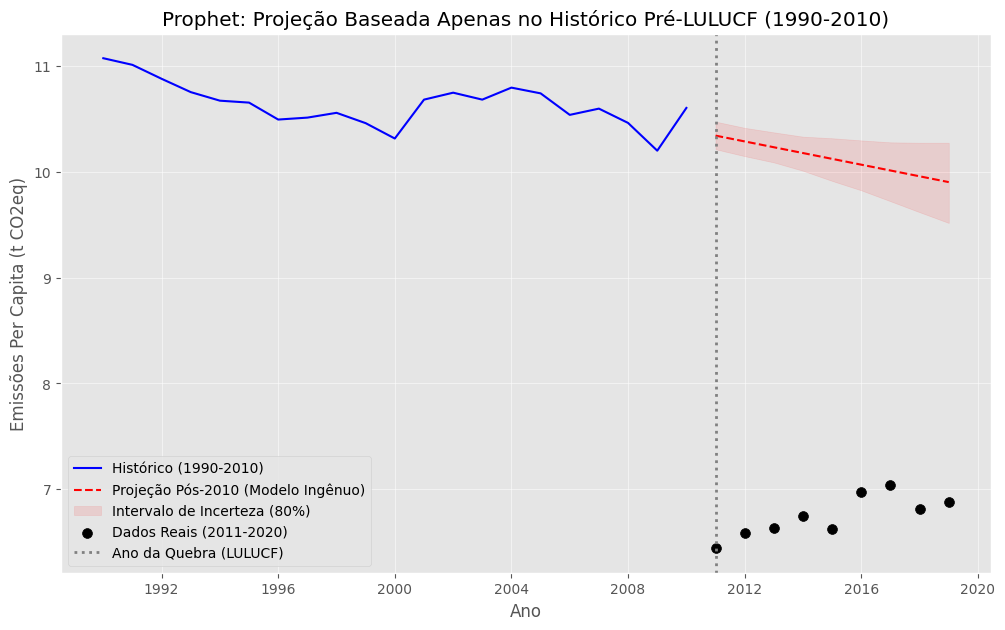


--- Análise da Divergência (2011-2020) ---
RMSE (Root Mean Squared Error): 3.39
MAPE (Mean Absolute Percentage Error): 50.20%


In [ ]:
# Bloco 3: Visualização e Análise do Erro

# Print data types and unique values of 'ds' in both dataframes before merging
print("df_test 'ds' dtype:", df_test['ds'].dtype)
print("forecast_test 'ds' dtype:", forecast_test['ds'].dtype)
print("\nUnique 'ds' values in df_test:", df_test['ds'].unique())
print("Unique 'ds' values in forecast_test:", forecast_test['ds'].unique())


# 1. Merge dos Dados Reais com a Projeção
validation_df = df_test.merge(
    forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left'
)

# Check for NaNs after merge
print("\nNaNs in validation_df['y'] after merge:", validation_df['y'].isnull().sum())
print("NaNs in validation_df['yhat'] after merge:", validation_df['yhat'].isnull().sum())


# 2. Visualização da Divergência (Prova da Quebra Estrutural)
plt.figure(figsize=(12, 7))

# Plotar o histórico (Treinamento)
plt.plot(df_train['ds'], df_train['y'], label='Histórico (1990-2010)', color='blue')

# Plotar a Projeção (2011-2020)
plt.plot(validation_df['ds'], validation_df['yhat'], label='Projeção Pós-2010 (Modelo Ingênuo)', color='red', linestyle='--')
plt.fill_between(
    validation_df['ds'], validation_df['yhat_lower'], validation_df['yhat_upper'],
    color='red', alpha=0.1, label='Intervalo de Incerteza (80%)'
)

# Plotar os Dados Reais (2011-2020)
plt.scatter(validation_df['ds'], validation_df['y'], label='Dados Reais (2011-2020)', color='black', marker='o', s=50)

# Linha da Quebra Estrutural
plt.axvline(x=pd.to_datetime('2011-01-01'), color='gray', linestyle=':', linewidth=2, label='Ano da Quebra (LULUCF)')

plt.title('Prophet: Projeção Baseada Apenas no Histórico Pré-LULUCF (1990-2010)')
plt.xlabel('Ano')
plt.ylabel('Emissões Per Capita (t CO2eq)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# 3. Cálculo e Análise do Erro (Validação da Tese)
# Drop rows with NaNs in 'y' or 'yhat' before calculating error metrics
validation_df_cleaned = validation_df.dropna(subset=['y', 'yhat']).copy()


# Calcular o erro entre a previsão (yhat) e o valor real (y)
rmse = np.sqrt(mean_squared_error(validation_df_cleaned['y'], validation_df_cleaned['yhat']))
mape = mean_absolute_percentage_error(validation_df_cleaned['y'], validation_df_cleaned['yhat']) * 100

print("\n--- Análise da Divergência (2011-2020) ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

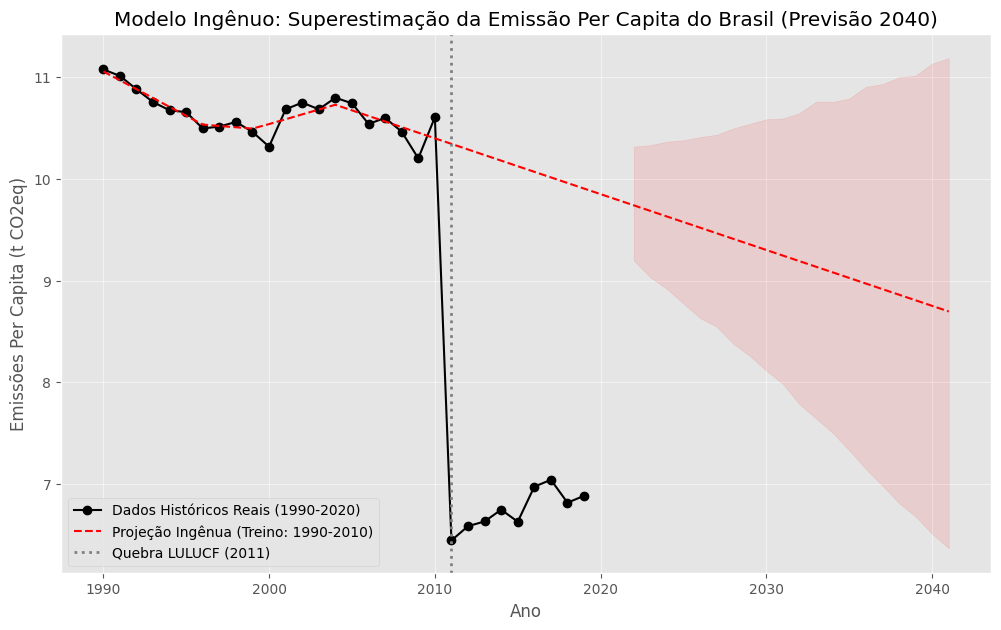


Projeção Ingênua para 2040: 8.70 t CO2eq/pessoa.


In [ ]:
# Bloco 4 (Revisado): Projeção Estendida do Modelo Ingênuo (Treinado em 1990-2010)

# O modelo 'm' (treinado em 1990-2010) já existe.

# 1. Preparar o Future DataFrame (Previsão até 2040)
# Generate enough future periods to definitely include 2040
# The history ends in 2010. To reach 2040, we need 2040 - 2010 = 30 periods.
# Let's generate a few more to be safe, e.g., 31 periods (until 2041)
future_full = m.make_future_dataframe(periods=(2040 - 2010) + 1, freq='Y', include_history=True)


# 2. Gerar a Projeção Completa
forecast_full = m.predict(future_full)

# 3. Visualização da Superestimação
plt.figure(figsize=(12, 7))

# Plotar o histórico completo (1990-2020)
plt.plot(df_prophet_br['ds'], df_prophet_br['y'], label='Dados Históricos Reais (1990-2020)', color='black', marker='o')

# Plotar a Projeção Ingênua (extrapolada até 2040)
plt.plot(forecast_full['ds'], forecast_full['yhat'], label='Projeção Ingênua (Treino: 1990-2010)', color='red', linestyle='--')
plt.fill_between(
    forecast_full[forecast_full['ds'].dt.year > 2020]['ds'],
    forecast_full[forecast_full['ds'].dt.year > 2020]['yhat_lower'],
    forecast_full[forecast_full['ds'].dt.year > 2020]['yhat_upper'],
    color='red', alpha=0.1,
)

# Destacar a Quebra Estrutural
plt.axvline(x=pd.to_datetime('2011-01-01'), color='gray', linestyle=':', linewidth=2, label='Quebra LULUCF (2011)')

plt.title('Modelo Ingênuo: Superestimação da Emissão Per Capita do Brasil (Previsão 2040)')
plt.xlabel('Ano')
plt.ylabel('Emissões Per Capita (t CO2eq)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Resumo da Previsão Ingênua (para discussão)
yhat_2040_ingenuo = forecast_full[forecast_full['ds'].dt.year == 2040]['yhat'].iloc[0]
print(f"\nProjeção Ingênua para 2040: {yhat_2040_ingenuo:.2f} t CO2eq/pessoa.")

In [ ]:
# Bloco 5 (Revisado): Treinamento Otimizado (Pós-2011) e Projeção até 2040

# O df_train_opt (2011-2020) já existe.

# 1. Configurar e Treinar o Modelo Otimizado (m_opt)
m_opt = Prophet(
    yearly_seasonality=False,
    changepoint_prior_scale=0.05
)
m_opt.fit(df_train_opt)

# 2. Preparar o Future DataFrame (Previsão até 2040)
# Generate enough future periods to definitely include 2040
# Generate 30 periods from the last date of history (2019), reaching up to 2049
num_future_periods = 30

# Use 'YS' frequency to match the training data's date format
future_opt = m_opt.make_future_dataframe(periods=num_future_periods, freq='YS', include_history=True)

# Print the last date in the future dataframe to verify it goes past 2040
print("Last date in future_opt:", future_opt['ds'].max())

# 3. Gerar a Projeção Otimizada
forecast_opt = m_opt.predict(future_opt)

# 4. Projeção Otimizada para 2040
# Filter for the year 2040 after generating a longer forecast
forecast_2040 = forecast_opt[forecast_opt['ds'].dt.year == 2040]

# Check if forecast for 2040 exists before accessing iloc[0]
if not forecast_2040.empty:
    yhat_2040_otimizado = forecast_2040['yhat'].iloc[0]

    print(f"\n✅ Modelo Otimizado (Pós-2011) treinado com previsão até 2040.")
    print(f"Projeção Otimizada para 2040: {yhat_2040_otimizado:.2f} t CO2eq/pessoa.")
else:
    yhat_2040_otimizado = float('nan') # Assign NaN if 2040 is not in the forecast
    print("\n✅ Modelo Otimizado (Pós-2011) treinado.")
    print("Projeção Otimizada para 2040: Ano 2040 não encontrado na previsão.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m04qcbq/mgdmtqg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8m04qcbq/mi8_g48k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58075', 'data', 'file=/tmp/tmp8m04qcbq/mgdmtqg3.json', 'init=/tmp/tmp8m04qcbq/mi8_g48k.json', 'output', 'file=/tmp/tmp8m04qcbq/prophet_modeltkm22sba/prophet_model-20251002041223.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:12:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Last date in future_opt: 2049-01-01 00:00:00

✅ Modelo Otimizado (Pós-2011) treinado com previsão até 2040.
Projeção Otimizada para 2040: 7.59 t CO2eq/pessoa.


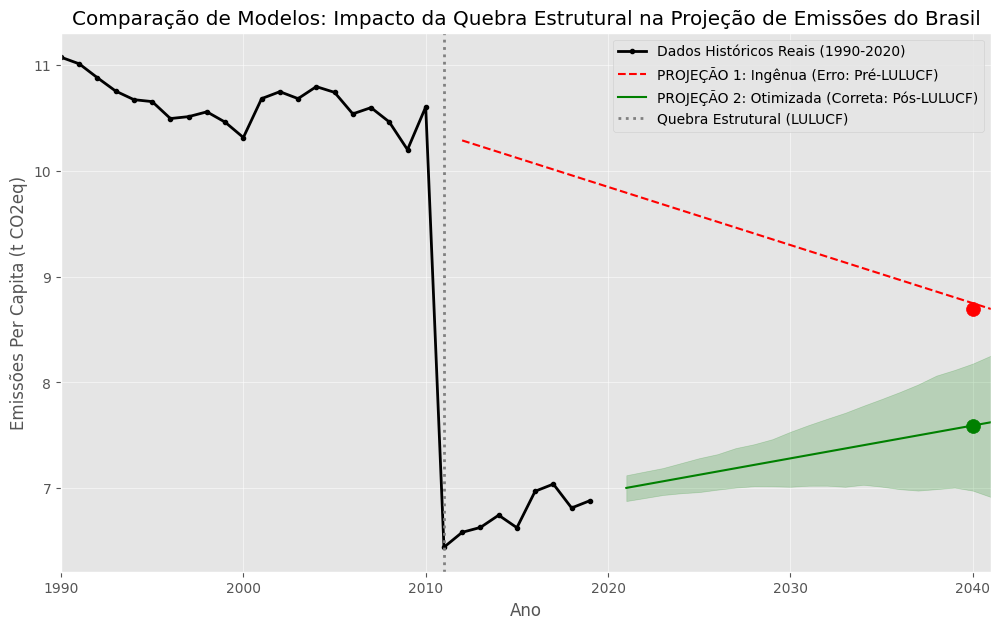


--- Conclusão da Comparação ---
Projeção Ingênua (1990-2010) para 2040: 8.70 t CO2eq/pessoa
Projeção Otimizada (2011-2020) para 2040: 7.59 t CO2eq/pessoa

A diferença na projeção de 2040 é de: 1.10 t CO2eq/pessoa.
Esta diferença prova a importância do pré-processamento de dados em Séries Temporais.


In [ ]:
# Bloco 6 (Revisado): Comparação Final de Modelos (Ingênuo vs. Otimizado)

plt.figure(figsize=(12, 7))

# 1. Plotar o Histórico COMPLETO (1990-2020)
plt.plot(df_prophet_br['ds'], df_prophet_br['y'], label='Dados Históricos Reais (1990-2020)', color='black', linewidth=2, marker='.')

# 2. Plotar a Projeção Ingênua (1990-2010 -> 2040)
# Ajusta o limite da projeção ingênua para garantir que ela não comece antes de 2011
ingenuous_proj = forecast_full[forecast_full['ds'].dt.year >= 2011]
plt.plot(ingenuous_proj['ds'], ingenuous_proj['yhat'], label='PROJEÇÃO 1: Ingênua (Erro: Pré-LULUCF)', color='red', linestyle='--')

# 3. Plotar a Projeção Otimizada (2011-2020 -> 2040)
# Apenas a parte da previsão (2021-2040)
forecast_opt_proj = forecast_opt[forecast_opt['ds'].dt.year >= 2021]
plt.plot(forecast_opt_proj['ds'], forecast_opt_proj['yhat'], label='PROJEÇÃO 2: Otimizada (Correta: Pós-LULUCF)', color='green', linestyle='-')
plt.fill_between(
    forecast_opt_proj['ds'], forecast_opt_proj['yhat_lower'], forecast_opt_proj['yhat_upper'],
    color='green', alpha=0.2
)

# 4. Linha da Quebra Estrutural
plt.axvline(x=pd.to_datetime('2011-01-01'), color='gray', linestyle=':', linewidth=2, label='Quebra Estrutural (LULUCF)')

# 5. Destaque das Projeções de 2040
plt.scatter(pd.to_datetime('2040-01-01'), yhat_2040_ingenuo, color='red', s=100, zorder=5)
plt.scatter(pd.to_datetime('2040-01-01'), yhat_2040_otimizado, color='green', s=100, zorder=5)

plt.title('Comparação de Modelos: Impacto da Quebra Estrutural na Projeção de Emissões do Brasil')
plt.xlabel('Ano')
plt.ylabel('Emissões Per Capita (t CO2eq)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.5)
# Ajusta o limite do eixo X para incluir 2040
plt.xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2041-01-01'))
plt.show()

print("\n--- Conclusão da Comparação ---")
print(f"Projeção Ingênua (1990-2010) para 2040: {yhat_2040_ingenuo:.2f} t CO2eq/pessoa")
print(f"Projeção Otimizada (2011-2020) para 2040: {yhat_2040_otimizado:.2f} t CO2eq/pessoa")
print(f"\nA diferença na projeção de 2040 é de: {(yhat_2040_ingenuo - yhat_2040_otimizado):.2f} t CO2eq/pessoa.")
print("Esta diferença prova a importância do pré-processamento de dados em Séries Temporais.")